In [15]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
class CFG:
  k = 10
  reward_means = torch.randint(-3, 8, (k,)).float()
  reward_stds = torch.rand(10) + 3.0

In [39]:
class kArmedTestBed:
  def __init__(self, cfg):
    self.cfg = cfg
    self.k = cfg.k
    self.actions = [i for i in range(1, self.k + 1)]
    self.reward_means = cfg.reward_means
    self.reward_stds = cfg.reward_stds
    self.rewards = [[] for _ in range(self.k)]

  def populate_rewards(self, samples_per_distribution=1000):
    for i in range(self.k):
      for _ in range(samples_per_distribution):
        self.rewards[i].append(torch.normal(self.reward_means[i], self.reward_stds[i]).item())

  def plot_rewards(self):
    data = [self.rewards[i] for i in range(self.k)]

    # Set style for better visualization
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))

    # Create violin plot
    sns.violinplot(data=data, inner="quartile", color='#4A90E2', edgecolor='#2E6DA4')

    # Set x-axis labels from 1 to k
    plt.xticks(ticks=range(self.k), labels=self.actions)

    plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

    # Labels and title
    plt.xlabel('Action')
    plt.ylabel('Reward distribution')
    plt.title('Reward Distribution by Action')

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

In [40]:
test_bed = kArmedTestBed(CFG)
test_bed.populate_rewards()

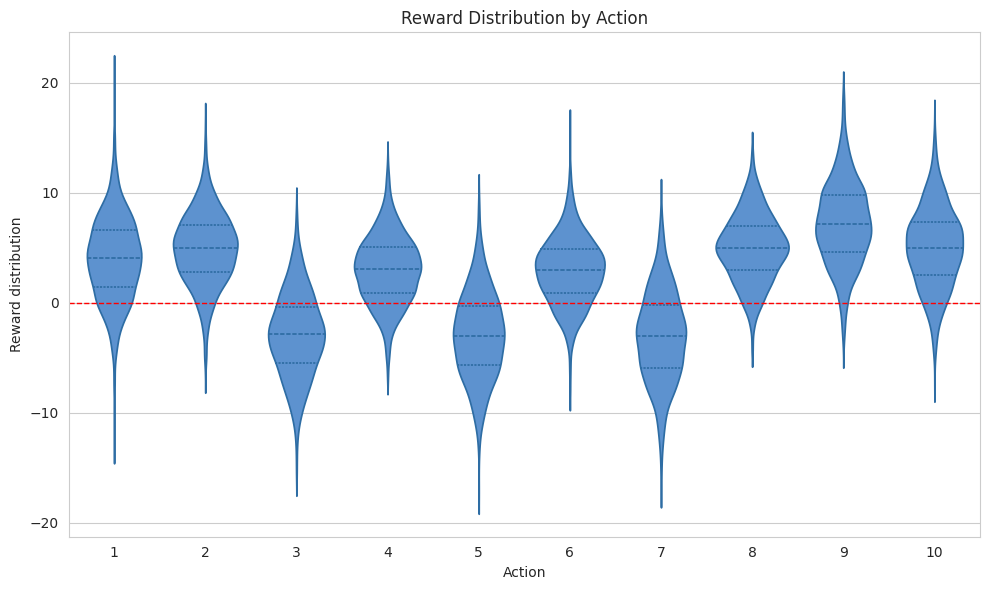

In [41]:
test_bed.plot_rewards()